In [1]:
from IPython.display import display, Latex
from IPython.core.display import HTML
%reset -f
%matplotlib inline
%autosave 300
from matplotlib.pylab import *
import time
from scipy.sparse import  spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix, spdiags

Autosaving every 300 seconds


## Elément fini $\mathbb P_3$
on construit les matrices élémentaires pour l'élément fini $\mathbb P_3$ Hermite:
$$
\left\{      
K= [0,1], \Sigma=\{p\to p(0), p\to p(1);~ p\to p'(0), ~p\to p'(1) \}, \mathbb P_3
\right \}
$$

Les fonctions de base de l'élément $[0,h]$ sont

$$
\varphi_1(x)=(\frac x h-1)^2(2\frac x h+1).
$$

$$
\varphi_2(x)=(\frac x h-1)^2(\frac x h).
$$
$$
\varphi_3(x)=(\frac x h)^2(-2\frac x h+3).
$$
$$
\varphi_4(x)=(\frac x h)^2(\frac x h-1).
$$




In [2]:
import sympy as sy
xs,hs=sy.symbols('xs hs',real='True')
phi1=(xs/hs-1)**2*(2*xs/hs+1)
phi2=(xs/hs-1)**2*(xs/hs)
phi3=(xs/hs)**2*(-2*xs/hs+3)
phi4=(xs/hs)**2*(xs/hs-1)

#sy.plot(phi4.subs(hs,1), (xs, 0, 1))
phi1p=sy.diff(phi1,xs)
phi2p=sy.diff(phi2,xs)
phi3p=sy.diff(phi3,xs)
phi4p=sy.diff(phi4,xs)
print(sy.integrate(phi1p**2,(xs,0,hs)))
print(sy.integrate(phi1p*phi2p,(xs,0,hs)))
print(sy.integrate(phi1p*phi3p,(xs,0,hs)))
print(sy.integrate(phi1p*phi4p,(xs,0,hs)))
print()
#
print(sy.integrate(phi2p**2,(xs,0,hs)))
print(sy.integrate(phi2p*phi3p,(xs,0,hs)))
print(sy.integrate(phi2p*phi4p,(xs,0,hs)))
print()
#
print(sy.integrate(phi3p**2,(xs,0,hs)))
print(sy.integrate(phi3p*phi4p,(xs,0,hs)))
print()
#
print(sy.integrate(phi4p**2,(xs,0,hs)))

6/(5*hs)
1/(10*hs)
-6/(5*hs)
1/(10*hs)

2/(15*hs)
-1/(10*hs)
-1/(30*hs)

6/(5*hs)
-1/(10*hs)

2/(15*hs)


In [3]:
#matrice élémentaire de masse
print(sy.integrate(phi1**2,(xs,0,hs)))
print(sy.integrate(phi1*phi2,(xs,0,hs)))
print(sy.integrate(phi1*phi3,(xs,0,hs)))
print(sy.integrate(phi1*phi4,(xs,0,hs)))
print()
#
print(sy.integrate(phi2**2,(xs,0,hs)))
print(sy.integrate(phi2*phi3,(xs,0,hs)))
print(sy.integrate(phi2*phi4,(xs,0,hs)))
print()
#
print(sy.integrate(phi3**2,(xs,0,hs)))
print(sy.integrate(phi3*phi4,(xs,0,hs)))
print()
#
print(sy.integrate(phi4**2,(xs,0,hs)))

13*hs/35
11*hs/210
9*hs/70
-13*hs/420

hs/105
13*hs/420
-hs/140

13*hs/35
-11*hs/210

hs/105


# Résolution d'un problème elliptique
On veut résoudre 
$$
\begin{cases}
-u''+u=f \text{ sur } ]0,L[ \\
u'(0)=u'(L)=0.
\end {cases}
$$
La formulation variationnelle s'écrit
$$
\left (\mathcal V\right ) \begin {cases}
\text{Trouver } u\in H^1(]0,1[)\text{ tel que }\forall v\in H^1(]0,L[)\\
\int_0^L u'(x)v'(x)\,dx+\int_0^L u(x)v(x)\,dx=\int_0^L f(x)v(x)\,dx.
\end {cases}
$$
Le code basé sur une approximation élément fini $\mathbb P_3$ Hermite est le suivant.

On cherche à résoudre le problème approché en dimension finie,
$$
\left (\mathcal V_h\right ) \begin {cases}
\text{Trouver } u_h\in V_h\text{ tel que }\forall v\in V_h\\
\int_0^L u_h'(x)v'(x)\,dx+\int_0^L u_h(x)v(x)\,dx=\int_0^L f(x)v(x)\,dx,
\end {cases}
$$
où $V_h\subset H^1(]0,L[)$ est de dimension finie et 
$$
V_h=\{ v\in \mathcal C^1(]0,L[)\text{ tel que }v_{|[x_i,x_{i+1}]  }   \in \mathbb P_3,~\forall 0\le i< N-1\},
$$
avec $x_i=ih$ où $h$ est le pas de la subdivision uniforme de $[0,L]$, soit $h=\frac L {N-1}$.
On a vu en cours que $\dim V_h=2N$.
Pour assembler le second membre, on va supposer que $f\in V_h$ et ainsi décomposé $f$ sur la base de $V_h$ constituée des fonctions de base élémentaire. Les coordonnées de $f$ dans cette base sont donc l'évaluation des degrés de liberté de $f$. Si $F_{ddl}$ est ce vecteur alors le second membre du système linéaire est alors
$$
Id~ F_{ddl},
$$
où $Id$ est la matrice construite, par cet élément fini, sur la forme bilinéaire $(u,v)\to \int_0^L u(x)v(x)\,dx$.

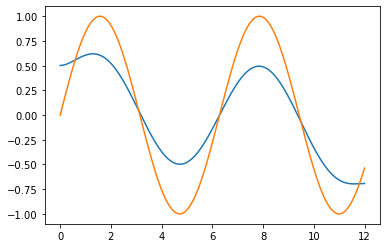

In [4]:
#
N=300
L=12
h=L/(N-1)

A =lil_matrix((2*N,2*N))
Id =lil_matrix((2*N,2*N))
#construction de la matrice élémentaire du terme integral
elrig=zeros((4,4))
elmasse=zeros((4,4))
elrig[0,:]=[6/5,0.1,-6/5,0.1]
elrig[1,1:]=[2/15,-0.1,-1/30]
elrig[2,2:]=[6/5,-0.1]
elrig[3,3]=2/15
elrig/=h
for i in range(4):
    for j in range(i+1,4):
        elrig[j,i]=elrig[i,j]
#print(elrig)
elmasse[0,:]=[13/35,11/210,9/70,-13/420]
elmasse[1,1:]=[1/105,13/420,-1/140]
elmasse[2,2:]=[13/35,-11/210]
elmasse[3,3]=1/105
elmasse*=h

#print(elmasse)
for i in range(4):
    for j in range(i+1,4):
        elmasse[j,i]=elmasse[i,j]
el=elmasse+elrig
#print(el)
#Parcours des éléments
for k in range(N-1):
    S=array([2*k,2*k+1,2*k+2,2*k+3])# ce tableau contient les numéros des 3 ddl
    for i in range(4):
        for j in range(4):
            A[S[i],S[j]]=A[S[i],S[j]]+el[i,j]
            Id[S[i],S[j]]=Id[S[i],S[j]]+elmasse[i,j]

#conversion en csr (compressed storage row) pour resolution system
A=A.tocsr()
Id=Id.tocsr()


#construction du second membre
x=linspace(0,L,N)
dx=x[1]-x[0]
f=sin(x)
df=cos(x)
sm=zeros(2*N)
sm[0::2]=f
sm[1::2]=df
sm=Id@sm

#resolution systeme creux
import time
start = time.time()
U=spsolve(A,sm)
uval=U[0::2]
plot(x,uval);
plot(x,f);
#print('simu time',time.time()-start)


## Problème du bilaplacien
On veut résoudre 
$$
\begin{cases}
-u^{(4)}+u=f \text{ sur } ]0,L[ \\
u"(0)=u^{(3)}(0)=u"(L)=u^{(3)}(L)=0.
\end {cases}
$$
Il s'agit de CL de type Neumann puisque la formulation variationnelle s'écrit
$$
\left (\mathcal V\right ) \begin {cases}
\text{Trouver } u\in H^2(]0,1[)\text{ tel que }\forall v\in H^2(]0,L[)\\
\int_0^L u"(x)v"(x)\,dx+\int_0^L u(x)v(x)\,dx=\int_0^L f(x)v(x)\,dx.
\end {cases}
$$

In [5]:
phipp=sy.zeros(4)
phipp[0]=sy.diff(phi1p,xs).subs(hs,1)
phipp[1]=sy.diff(phi2p,xs).subs(hs,1)
phipp[2]=sy.diff(phi3p,xs).subs(hs,1)
phipp[3]=sy.diff(phi4p,xs).subs(hs,1)
M=sy.zeros(4,4)
for i in range (4):
    for j in range(4):
        M[i,j]=sy.integrate(phipp[i]*phipp[j],(xs,0,1))
M

Matrix([
[ 12,  6, -12,  6],
[  6,  4,  -6,  2],
[-12, -6,  12, -6],
[  6,  2,  -6,  4]])

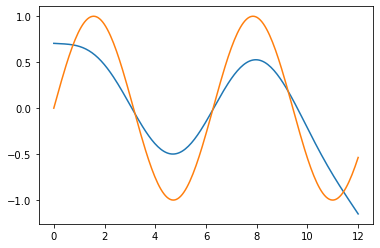

In [6]:
N=200
L=12
h=L/(N-1)

B =lil_matrix((2*N,2*N))
Id =lil_matrix((2*N,2*N))
elmasse=zeros((4,4))
#construction de la matrice élémentaire du terme integral
elcoq=array(M)/h**3
elmasse[0,:]=[13/35,11/210,9/70,-13/420]
elmasse[1,1:]=[1/105,13/420,-1/140]
elmasse[2,2:]=[13/35,-11/210]
elmasse[3,3]=1/105
elmasse*=h
#Parcours des éléments
for k in range(N-1):
    S=array([2*k,2*k+1,2*k+2,2*k+3])# ce tableau contient les numéros des 3 ddl
    for i in range(4):
        for j in range(4):
            B[S[i],S[j]]=B[S[i],S[j]]+elcoq[i,j]
            Id[S[i],S[j]]=Id[S[i],S[j]]+elmasse[i,j]


#conversion en csr (compressed storage row) pour resolution system
B=B+Id
B=B.tocsr()
#construction du second membre



#construction du second membre
x=linspace(0,L,N)
dx=x[1]-x[0]
f=sin(x)
df=cos(x)
sm=zeros(2*N)
sm[0::2]=f
sm[1::2]=df
sm=Id@sm

#resolution systeme creux
import time
start = time.time()
U=spsolve(B,sm)
uval=U[0::2]
plot(x,uval);
plot(x,f);
#print('simu time',time.time()-start)


## Automatisation de la construction des matrices élémentaires

### $\mathbb P_3$ Hermite en dimension 2
On a vu que le calcul symbolique est vite incontournable pour calculer les coefficients des matrices élémentaires sans erreur ou perte de temps. On propose ici un algorithme facilement généralisable pour calculer des matrices élémentaires, de masse, de rigidité ou autre.

L'idée est de construire les fonctions de base classiques des monômes, de les évaluer sur les degré de liberté de l'élément fini choisi. Puis de procéder au changement de base.
Sur l'exemple qui suit, la construction est proposée pour l'élément fini $\mathbb P_3$ Hermite:
$$
\begin{align*}
&\left\{  K,    \Sigma_K,~ \mathbb P_3\right \}\\
&K= \widehat{S_0(0,0),S_1(1,0),S_2(0,1)}, \\
&\Sigma_K=\{p\to p(S_i),~ i=0,1,2;~ p\to \partial_x p(S_i),~ i=0,1,2;~ p\to \partial_y p(S_i),~i=0,1,2,p\to p(\frac 1 3(S_0+S_1+S_2)) \}.
\end {align*}
$$

In [21]:
# Construction fonction de base P3 Hermite en dim=2
import sympy as sy
x,y=sy.symbols('x y',real='True')
l=0
M=sy.zeros(10,10)
monom=sy.zeros(10,1)
for i in range(4):
    for j in range(0,i+1):
        k=i-j
        monom[l]=x**k * y**j
        l+=1
dxmon=sy.diff(monom,x)
dymon=sy.diff(monom,y)
c=0
tier=sy.Rational(1,3)
for (Sx,Sy) in [(0,0),(1,0),(0,1)]:#indice sommet
    for i in range(10):

    
        M[i,c  ]=monom[i].subs(x,Sx).subs(y,Sy)#ddl eval au sommet
        M[i,c+1]=dxmon[i].subs(x,Sx).subs(y,Sy)#ddl eval dx au sommet
        M[i,c+2]=dymon[i].subs(x,Sx).subs(y,Sy)#ddl eval dy au sommet
    c+=3
for i in range(10):#ddl au centre de gravité
        M[i,9  ]=monom[i].subs(x,tier).subs(y,tier)
phi=M.solve(monom)
mat=phi*phi.T
integ=sy.integrate(mat,(y,0,1-x))
eleme=sy.simplify(sy.integrate(integ,(x,0,1)))
massep3=array(eleme)   
eleme  
        

Matrix([
[ 313/5040,  53/10080,  53/10080,     1/720,  -1/2520, -13/10080,     1/720, -13/10080,  -1/2520,  3/112],
[ 53/10080,    1/1260,    1/5040,  17/10080,  -1/2520,  -1/10080, -13/10080,   -1/5040,   1/3360, 3/1120],
[ 53/10080,    1/5040,    1/1260, -13/10080,   1/3360,   -1/5040,  17/10080,  -1/10080,  -1/2520, 3/1120],
[    1/720,  17/10080, -13/10080,  313/5040, -53/5040,  53/10080,     1/720,  17/10080,  -1/2520,  3/112],
[  -1/2520,   -1/2520,    1/3360,  -53/5040,    1/504,   -1/1008,   -1/2520,   -1/2520,  1/10080, -3/560],
[-13/10080,  -1/10080,   -1/5040,  53/10080,  -1/1008,    1/1260,  17/10080,    1/2016,  -1/2520, 3/1120],
[    1/720, -13/10080,  17/10080,     1/720,  -1/2520,  17/10080,  313/5040,  53/10080, -53/5040,  3/112],
[-13/10080,   -1/5040,  -1/10080,  17/10080,  -1/2520,    1/2016,  53/10080,    1/1260,  -1/1008, 3/1120],
[  -1/2520,    1/3360,   -1/2520,   -1/2520,  1/10080,   -1/2520,  -53/5040,   -1/1008,    1/504, -3/560],
[    3/112,    3/1120,    3/

In [22]:
dxphi=sy.diff(phi,x)
dyphi=sy.diff(phi,y)
mat=dxphi*dxphi.T#+dyphi*dyphi.T
integ=sy.integrate(mat,(y,0,1-x))
eleme=sy.simplify(sy.integrate(integ,(x,0,1)))
rigdxdxp3=array(eleme)
eleme

Matrix([
[199/180,  1/60,   7/36,   1/180,  -1/90,   1/36,   7/18,  -1/90,  -1/9,   -3/2],
[   1/60,  1/60,      0,   -1/60,      0,      0,      0,      0,     0,      0],
[   7/36,     0,  7/180,    1/36, -1/180,  1/180,   7/90, -1/180, -1/45,  -3/10],
[  1/180, -1/60,   1/36, 199/180, -19/90,   7/36,   7/18,  11/90,  -1/9,   -3/2],
[  -1/90,     0, -1/180,  -19/90,   1/18, -7/180,  -7/90,  -1/36,  1/45,   3/10],
[   1/36,     0,  1/180,    7/36, -7/180,  7/180,   7/90,   1/36, -1/45,  -3/10],
[   7/18,     0,   7/90,    7/18,  -7/90,   7/90, 49/180,  7/180, -7/90, -21/20],
[  -1/90,     0, -1/180,   11/90,  -1/36,   1/36,  7/180,  7/180, -1/90,  -3/20],
[   -1/9,     0,  -1/45,    -1/9,   1/45,  -1/45,  -7/90,  -1/90,  1/45,   3/10],
[   -3/2,     0,  -3/10,    -3/2,   3/10,  -3/10, -21/20,  -3/20,  3/10,  81/20]])

In [23]:
mat=dyphi*dyphi.T
integ=sy.integrate(mat,(y,0,1-x))
eleme=sy.simplify(sy.integrate(integ,(x,0,1)))
rigdydyp3=array(eleme)
eleme

Matrix([
[199/180,   7/36,  1/60,   7/18,  -1/9,  -1/90,   1/180,   1/36,  -1/90,   -3/2],
[   7/36,  7/180,     0,   7/90, -1/45, -1/180,    1/36,  1/180, -1/180,  -3/10],
[   1/60,      0,  1/60,      0,     0,      0,   -1/60,      0,      0,      0],
[   7/18,   7/90,     0, 49/180, -7/90,  7/180,    7/18,   7/90,  -7/90, -21/20],
[   -1/9,  -1/45,     0,  -7/90,  1/45,  -1/90,    -1/9,  -1/45,   1/45,   3/10],
[  -1/90, -1/180,     0,  7/180, -1/90,  7/180,   11/90,   1/36,  -1/36,  -3/20],
[  1/180,   1/36, -1/60,   7/18,  -1/9,  11/90, 199/180,   7/36, -19/90,   -3/2],
[   1/36,  1/180,     0,   7/90, -1/45,   1/36,    7/36,  7/180, -7/180,  -3/10],
[  -1/90, -1/180,     0,  -7/90,  1/45,  -1/36,  -19/90, -7/180,   1/18,   3/10],
[   -3/2,  -3/10,     0, -21/20,  3/10,  -3/20,    -3/2,  -3/10,   3/10,  81/20]])

In [25]:
mat=dxphi*dyphi.T
integ=sy.integrate(mat,(y,0,1-x))
eleme=sy.simplify(sy.integrate(integ,(x,0,1)))
rigdxdyp3=array(eleme)
eleme

Matrix([
[349/360,  49/360, 13/360, 91/360, -13/180,  1/120, -89/360,  1/120,   1/36, -39/40],
[ 13/360,   1/120,   1/72,  7/360,  -1/180, -1/360,   7/360,  1/360, -1/180,  -3/40],
[ 49/360,    1/72,  1/120,  7/360,  -1/180,  1/360, -29/360, -1/360,   1/90,  -3/40],
[-89/360, -29/360,  7/360, 49/360,  -7/180, 19/120, 229/360, 19/120,  -5/36, -21/40],
[   1/36,    1/90, -1/180, -7/180,    1/90,  -1/60,   -5/36,  -1/30,   1/36,   3/20],
[  1/120,  -1/360,  1/360,  7/120,   -1/60, 11/360,  19/120, 13/360,  -1/30,  -9/40],
[ 91/360,   7/360,  7/360, 49/360,  -7/180,  7/120,  49/360,  7/120, -7/180, -21/40],
[  1/120,   1/360, -1/360,  7/120,   -1/60,  7/360,  19/120, 11/360,  -1/60,  -9/40],
[-13/180,  -1/180, -1/180, -7/180,    1/90,  -1/60,  -7/180,  -1/60,   1/90,   3/20],
[ -39/40,   -3/40,  -3/40, -21/40,    3/20,  -9/40,  -21/40,  -9/40,   3/20,  81/40]])

### $\mathbb P_3$ Hermite en dimension 3

$$
\begin{align*}
&\left\{  K,    \Sigma_K,~ \mathbb P_3\right \}\\
&K= K= \widehat{S_0(0,0,0),S_1(1,0,0),S_2(0,1,0),S_3(0,0,1)}, \\
&\Sigma_K=\{p\to p(S_i),~ i=0\cdots 3;~ p\to \partial_j p(S_i),~ i=0\cdots 3,~j=1\cdots 3,~p\to p(\frac 1 4(S_0+S_1+S_2+S_3)) \}.
 
\end {align*}

$$

In [11]:
#dim=3
import sympy as sy
x,y,z=sy.symbols('x y z',real='True')
M=sy.zeros(20,20)
monom=sy.zeros(20,1)
l=0
for i in range(4):
    for j in range(0,i+1):
        for k in range(0,j+1):
            px=i-j
            py=j-k
            pz=k
            monom[l] = x**px * y**py * z**pz
            #print(l,i,j,k)
            l+=1

dxmon=sy.diff(monom,x)
dymon=sy.diff(monom,y)
dzmon=sy.diff(monom,z)
c=0

for (Sx,Sy,Sz) in [(0,0,0),(1,0,0),(0,1,0),(0,0,1)]:#indice sommet
    for i in range(20):
        M[i,c  ]=monom[i].subs(x,Sx).subs(y,Sy).subs(z,Sz)
        M[i,c+1]=dxmon[i].subs(x,Sx).subs(y,Sy).subs(z,Sz)
        M[i,c+2]=dymon[i].subs(x,Sx).subs(y,Sy).subs(z,Sz)
        M[i,c+3]=dzmon[i].subs(x,Sx).subs(y,Sy).subs(z,Sz)
    c+=4
tier=sy.Rational(1,3)
sommets=sy.Matrix([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
for face in range(4):
    bary=sy.ones(1,3)
    bary-=sommets[face,:]
    bary*=tier
    for i in range(20):
        M[i,face+16]=monom[i].subs(x,bary[0]).subs(y,bary[1]).subs(z,bary[2])
#M
phi=M.solve(monom)

mat=phi*phi.T

integ=sy.integrate(mat,(z,0,1-x-y))
integ=sy.integrate(integ,(y,0,1-x))
eleme=sy.simplify(sy.integrate(integ,(x,0,1)))
eleme      
            

Matrix([
[253/30240, 97/181440, 97/181440, 97/181440, -23/45360,   1/11340,  -1/12096,  -1/12096, -23/45360,  -1/12096,   1/11340,  -1/12096, -23/45360,  -1/12096,  -1/12096,   1/11340,  -1/320,  1/6720,  1/6720,  1/6720],
[97/181440,   1/15120,   1/45360,   1/45360,   1/12960,  -1/45360, -1/181440, -1/181440,  -1/12096,  -1/90720,   1/60480,         0,  -1/12096,  -1/90720,         0,   1/60480, -1/3360, -1/6720,       0,       0],
[97/181440,   1/45360,   1/15120,   1/45360,  -1/12096,   1/60480,  -1/90720,         0,   1/12960, -1/181440,  -1/45360, -1/181440,  -1/12096,         0,  -1/90720,   1/60480, -1/3360,       0, -1/6720,       0],
[97/181440,   1/45360,   1/45360,   1/15120,  -1/12096,   1/60480,         0,  -1/90720,  -1/12096,         0,   1/60480,  -1/90720,   1/12960, -1/181440, -1/181440,  -1/45360, -1/3360,       0,       0, -1/6720],
[-23/45360,   1/12960,  -1/12096,  -1/12096, 253/30240, -97/60480, 97/181440, 97/181440, -23/45360,   1/12960,   1/11340,  -1/12096, -2

élément fini $\mathbb P_2$ Lagrange en dimension 2
$$
\left\{      
K= \widehat{S_0(0,0),S_1(1,0),S_2(0,1)}, \Sigma=\{p\to p(S_i),~ i=0\cdots 2;~ p\to  p(A_i),~ i=0\cdots 2 \}, \mathbb P_2
\right \},
$$
où les $A_i$ sont les milieux des arêtes du triangle $K$.

**Construire la matrice élémentaire de masse et de rigidité**

In [12]:
# Construction fonction de base P2 lagrange en dim=2

import sympy as sy
x,y=sy.symbols('x y ',real='True')
l=0
M=sy.zeros(6,6)
monom=sy.zeros(6,1)
for i in range(3):
    for j in range(0,i+1):
        k=i-j
        monom[l]=x**k * y**j
        l+=1

#...

## Mise en oeuvre sur maillage
On va mettre en oeuvre les éléments finis pour un maillage non structuré en 2D mais néanmoins admissible (mailles pas trop applaties, une arête est arête d'au plus deux éléments). La construction des matrices est la même que celle effectuée sur des maillages simples gérés manuellement. Il convient juste de récupérer les éléments géométriques fondamentaux: 
- la liste des sommets définis par les coordonnées des points
- la liste des éléments définis par les numéros des sommets (indices de la liste des sommets)
- la liste des arêtes du bord (définis par 2 numéros de sommet) et le type de condition limite; le cas échéant.
Cette dernière information est inutile avec des conditions limites de type Neumann homogène.

On va ici s'appuyer sur des maillages triangulaires 2D générés par la librairie matplotlib. De façon plus générale, il faudra disposer des informations ennoncées ci-dessus par un export depuis un mailleur ou par une construction manuelle (cf démo maillage de la sphère).

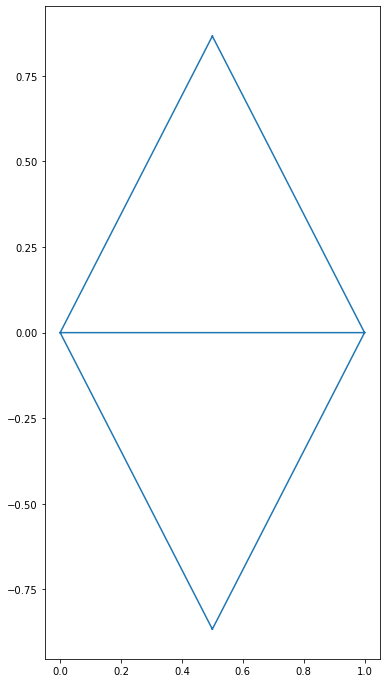

In [13]:
import matplotlib.tri as mptri
points = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2],  [0.5, -np.sqrt(3)/2]])
triang=mptri.Triangulation(points[:,0], points[:,1])

triang=mptri.Triangulation(points[:,0], points[:,1], )

plt.subplots(figsize=(6, 12))
plt.triplot(triang.x, triang.y, triang.triangles);

On peut afficher la liste des coordonnées des sommets (abscisses et ordonnées) ainsi que la liste des triangles:

In [14]:
print(triang.x)
print(triang.y)
print(triang.triangles)

[0.  1.  0.5 0.5]
[ 0.         0.         0.8660254 -0.8660254]
[[3 1 0]
 [0 1 2]]


On peut raffiner le maillage avant d'implémenter une méthode élément fini...

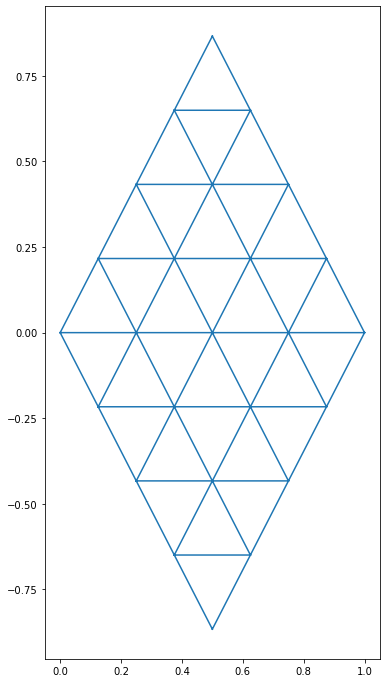

In [15]:

refiner = mptri.UniformTriRefiner(triang)
tri3 = refiner.refine_triangulation(subdiv=2)
plt.subplots(figsize=(6, 12))
plt.triplot(tri3.x, tri3.y, tri3.triangles);

### Calcul de la matrice
on pourra se référer à cette adresse: https://bthierry.pages.math.cnrs.fr/course-fem/lecture/elements-finis-triangulaires/contributions-elementaires/ pour comprendre le passage de l'élément de référence à un élément quelconque et les transformations induites sur la matrice élémentaire.
On se contente ici de procéder à l'approximation $\mathbb P_1$ sommet.

In [16]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix

tri3 = refiner.refine_triangulation(subdiv=5)

def matrice_rig(pt):
    surface=np.linalg.norm(np.cross(pt[2]-pt[0], pt[1]-pt[0]))*0.5
    #print(surface)
    B=np.array([[pt[2,1]-pt[0,1],pt[0,1]-pt[1,1]],[pt[0,0]-pt[2,0],pt[1,0]-pt[0,0]]])
    BtB=B.T@B
    nabphi=np.array([[-1,-1],[1,0],[0,1]])
    return nabphi@BtB@nabphi.T*0.25/surface
def matrice_masse(pt):
    masse_ref=(1/24)*array([[2,1,1],[1,2,1],[1,1,2]])
    surface=np.linalg.norm(np.cross(pt[2]-pt[0], pt[1]-pt[0]))*0.5
    #print(surface)
    return masse_ref*surface*2

#nbre de triangles
nt=np.size(tri3.triangles,0)
#nbre ddl (sommets)
nddl=np.size(tri3.x,0)
print("nombre de degré de liberté",nddl)
A =lil_matrix((nddl, nddl))
Id =lil_matrix((nddl, nddl))
for tr in range(nt):
    S=tri3.triangles[tr]
    pt=np.zeros((3,2))
    pt[:,0]=tri3.x[S]
    pt[:,1]=tri3.y[S]
    el  = matrice_rig(pt)
    elm = matrice_masse(pt)
    for i in range(3):
        for j in range(3):
            A[S[j],S[i]]+=el[i,j]+elm[i,j]
            Id[S[j],S[i]]+=elm[i,j]
A=A.tocsr()
Id=Id.tocsr()

nombre de degré de liberté 1089


### Calcul du second membre

In [17]:
#calcul du second membre
def f(coord):
    x=coord[0]
    y=coord[1]
    return (x**2+y**2)*2+1
# variante 1 pour SM: parcours des elements: remplissage par formule de quadrature
# SM=zeros(nddl)
# for tr in range(nt):
#     S=tri3.triangles[tr]
#     pt=np.zeros((3,2))
#     pt[:,0]=tri3.x[S]
#     pt[:,1]=tri3.y[S]
#     surface=np.linalg.norm(np.cross(pt[2]-pt[0], pt[1]-pt[0]))*0.5
#     for i in range(3):
#             G=pt[0,:]+pt[1,:]+pt[2,:]
#             G/=3
#             SM[S[i]]+=f(G)*surface/3

# Variante 2: remplissage par décomposition de f dans la base EF
F=f(array([tri3.x,tri3.y]) )
SM = Id@F



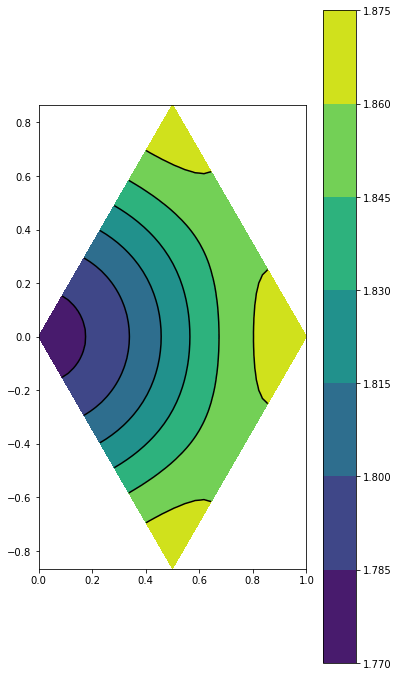

In [18]:

# resolution du problème de Neumann pour -u''+u=f
u=spsolve(A,SM)
fig1, ax1 = plt.subplots(figsize=(6, 12))
ax1.set_aspect('equal')
tcf = ax1.tricontourf(tri3, u);
fig1.colorbar(tcf)
ax1.tricontour(tri3, u, colors='k');

## Mise en oeuvre $\mathbb P_2$
- On va reprendre le même problème (même équation, même géométrie) résolu par élément fini $\mathbb P_2$ Lagrange.
- On doit préalablement construire les matrices élémentaires pour cet élément fini.
- On doit construire de nouvelles informations géométriques pour placer les degrés de liberté au milieu des arêtes.

In [ ]:
def matrice_rig(pt,rdxx,rdyy,rdxy):
    surface=np.linalg.norm(np.cross(pt[2]-pt[0], pt[1]-pt[0]))*0.5
    #print(surface)
    B=np.array([[pt[2,1]-pt[0,1],pt[0,1]-pt[1,1]],[pt[0,0]-pt[2,0],pt[1,0]-pt[0,0]]])
    BtB=B.T@B*0.25/surface
    return BtB[0,0]*rdxx+BtB[1,1]*rdyy+2*BtB[1,0]*rdxy
def matrice_masse(pt,masref):
    surface=np.linalg.norm(np.cross(pt[2]-pt[0], pt[1]-pt[0]))*0.5
    #print(surface)
    return masref*surface*2

In [ ]:
#nbre de triangles
nt=np.size(tri3.triangles,0)
#construction des ddl sur les aretes # on peut mieux faire en temps calcul...
def liste_A(LT):
    nt=len(LT)
    LA=[]
    LTA=[]
    for i in range(len(LT)):
        LTA.append([])
    for tr in range(nt):
        S=LT[tr]
        for i in range(3):
            arete=[min(S[i],S[(i+1)%3]),max(S[i],S[(i+1)%3])]
            if (arete in LA):
                LTA[tr].append(LA.index(arete))
            else:
                i=len(LA)
                LTA[tr].append(i)
                LA.append(arete)
    
    return LA,LTA

LA,LTA=liste_A(tri3.triangles)

**Finir le code en s'appuyant sur:**
- La numérotation globale de tous les degrés de liberté
- l'identification des degrés de liberté globaux pour chaque élément
- évaluer le terme source en chaque degré de liberté et en déduire le second membre
- ...

## Mise en oeuvre $\mathbb P_3$ Hermite en 2D
A faire pour s'entraîner...